In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.integrate import solve_ivp

%matplotlib widget

plt.rcParams['figure.figsize'] = [15, 10]


In [114]:
motor_max_torque = 0.16*2 #N*m 1/6 of a neo550
motor_max_vel = 1433.6 #rad/s, 1850kv at 7.4V
motor_I = 0.000001 #kg*m^2
def get_motor_torque(t, motor_vel):
    input = 1 #-1 to 1
    return motor_max_torque * (input - motor_vel/motor_max_vel)

In [119]:
total_mass = 0.200 #kg
g = 9.81

def jump_model(t, s, k, get_TSA_mult, get_link_mult): #k is spring constant in N/m
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    TSA_mult = get_TSA_mult(motor_pos)
    link_mult = get_link_mult(foot_pos)

    spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

    motor_torque = get_motor_torque(t, dmotor_pos)

    spring_force = -k * spring_pos

    motor_net_torque = motor_torque - spring_force/TSA_mult
    ddmotor_pos = motor_net_torque / motor_I

    foot_applied_force = spring_force*link_mult
    ddfoot_pos = (foot_applied_force - total_mass*g) / total_mass

    if foot_pos <= 0: ddfoot_pos = max(ddfoot_pos, 0)

    return [dmotor_pos, ddmotor_pos, dfoot_pos, ddfoot_pos]

In [120]:
max_extension = 0.15 #m
def liftoff(t, s, k, get_TSA_mult, get_link_mult):
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    if foot_pos < max_extension:

        TSA_mult = get_TSA_mult(motor_pos)
        link_mult = get_link_mult(foot_pos)

        spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

        spring_force = -k * spring_pos

        foot_applied_force = spring_force*link_mult
        foot_net_force = foot_applied_force - total_mass*g
        if foot_pos <= 0: foot_net_force = max(foot_net_force, 0)


        if foot_net_force < 0:
            return 0
        else:
            return 1
    else:
        return 0
liftoff.terminal = True



In [121]:
def solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot):
    t_span = (0, 0.25)
    s0 = (0, 0, 0, 0)
    # s0 = (0.1, 0, 0, 0)
    solution = solve_ivp(jump_model, t_span, s0, t_eval=np.arange(t_span[0], t_span[1], 0.001), events=[liftoff], args=(k, get_TSA_mult, get_link_mult))

    motor_pos_data = solution.y[0, :]
    motor_vel_data = solution.y[1, :]
    foot_pos_data = solution.y[2, :]
    foot_vel_data = solution.y[3, :]



    if doPlot:
        

        TSA_mult_data = np.vectorize(get_TSA_mult)(motor_pos_data)
        link_mult_data = np.vectorize(get_link_mult)(foot_pos_data)

        spring_pos_data = -motor_pos_data/TSA_mult_data + foot_pos_data*link_mult_data

        plt.figure()
        plt.plot(solution.t, np.zeros_like(solution.t), 'k')

        plt.plot(solution.t, motor_pos_data/max(abs(motor_pos_data)), 'o', markersize=1, label=f"motor_pos {round(max(abs(motor_pos_data)),4)}")
        plt.plot(solution.t, motor_vel_data/max(abs(motor_vel_data)), label=f"motor_vel {round(max(abs(motor_vel_data)),4)}")
        plt.plot(solution.t, np.full(solution.t.shape, motor_max_vel/max(abs(motor_vel_data))), label=f"motor_max_vel")
        plt.plot(solution.t, foot_pos_data/max(abs(foot_pos_data)), label=f"foot_pos {round(max(abs(foot_pos_data)),4)}")
        plt.plot(solution.t, foot_vel_data/max(abs(foot_vel_data)), label=f"foot_vel {round(max(abs(foot_vel_data)),4)}")

        plt.plot(solution.t, TSA_mult_data/max(abs(TSA_mult_data)), '--', label=f"TSA_mult {round(max(abs(TSA_mult_data)),4)}")
        plt.plot(solution.t, link_mult_data/max(abs(link_mult_data)), '--', label=f"link_mult {round(max(abs(link_mult_data)),4)}")
        plt.plot(solution.t, -spring_pos_data/max(abs(spring_pos_data)), label=f"spring_pos {round(max(abs(spring_pos_data)),4)}")

        plt.legend()

        plt.xlabel(f"time(s) {len(solution.t)} samples")
        plt.ylabel("normalized value")
        plt.title(f"k={k}, end_foot_vel={round(foot_vel_data[-1],4)}")


        # plt.figure()
        # plt.plot(foot_pos_data, np.zeros_like(foot_pos_data), 'k')
        # plt.plot(foot_pos_data, link_mult_data, '--', label=f"link_mult {round(max(abs(link_mult_data)),4)}")
        # plt.xlabel(f"foot_pos_data (m) {len(foot_pos_data)} samples")
        # plt.ylabel("link mechanical advantage")


        # plt.figure()
        # plt.plot(foot_vel_data, np.zeros_like(foot_vel_data), 'k')
        # plt.plot(foot_vel_data, motor_vel_data)
        # plt.xlabel(f"foot_vel_data (m/s) {len(foot_vel_data)} samples")
        # plt.ylabel("motor vel (rad/s)")




        print('avg motor speed proportion', np.mean(motor_vel_data)/motor_max_vel)

    return foot_vel_data[-1]


avg motor speed proportion 0.1626292608127802


4.815311088209912

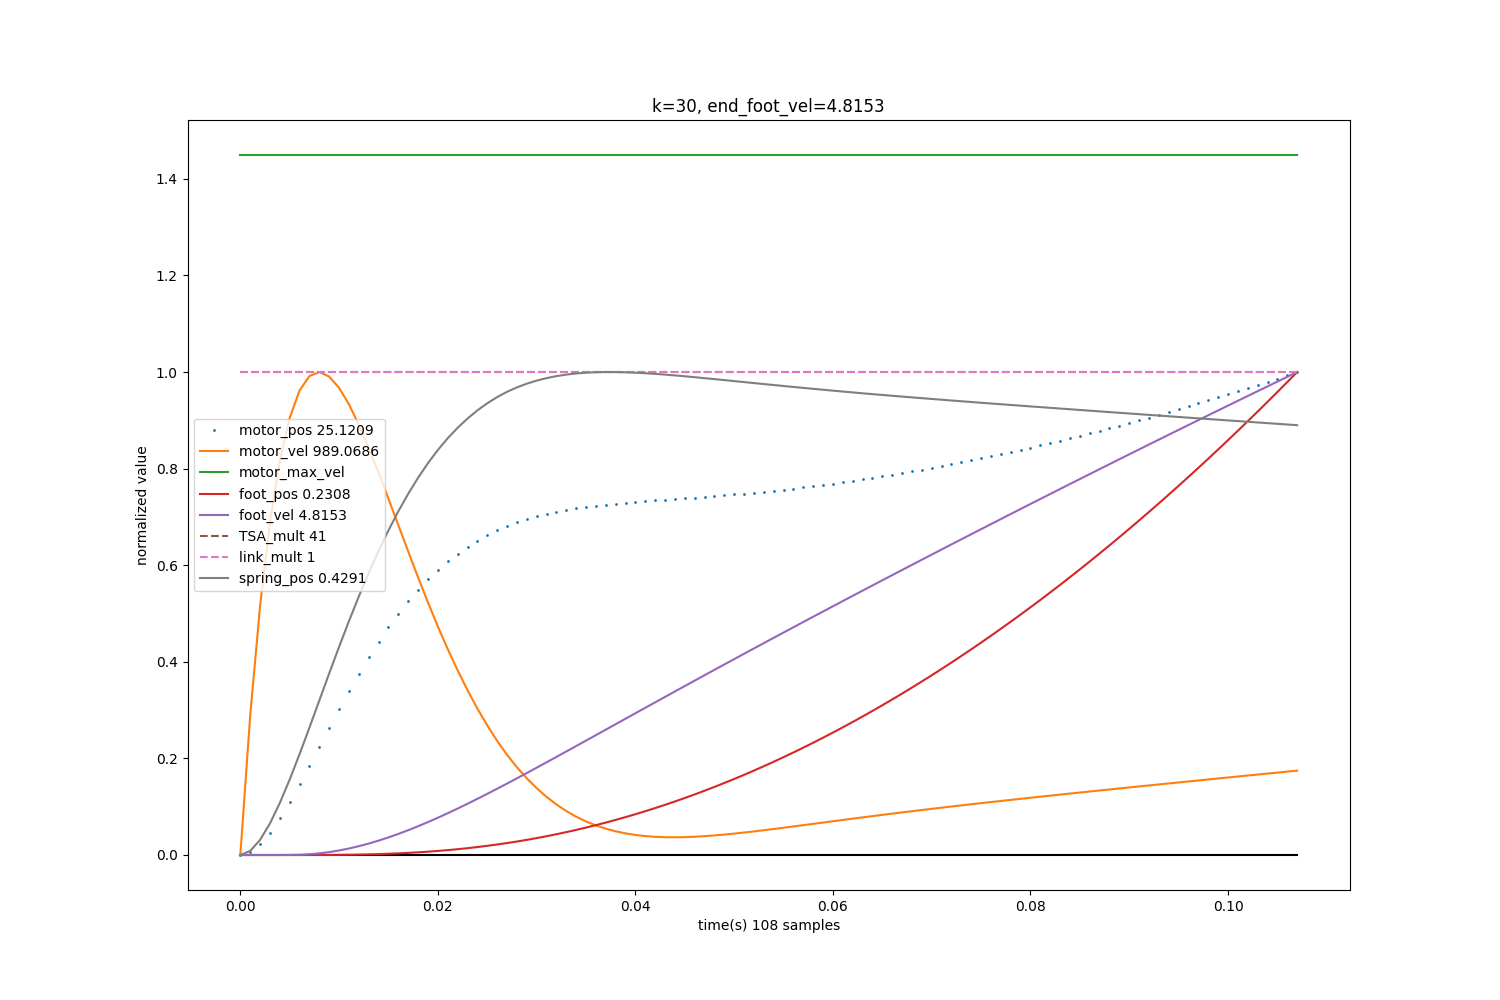

In [138]:
plt.close("all")

def get_TSA_mult(motor_pos):
    return 41

def get_link_mult(foot_pos):
    # if foot_pos < 0.02:
    #     return 1.4
    # elif foot_pos < 0.04:
    #     return 0.6
    # elif foot_pos < 0.06:
    #     return 0.4
    # else:
    #     return 0.2
    return 1
# solve_end_vel(30, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(50, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(70, get_TSA_mult, get_link_mult, True) 
solve_end_vel(30, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(110, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(180, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(300, get_TSA_mult, get_link_mult, True) 


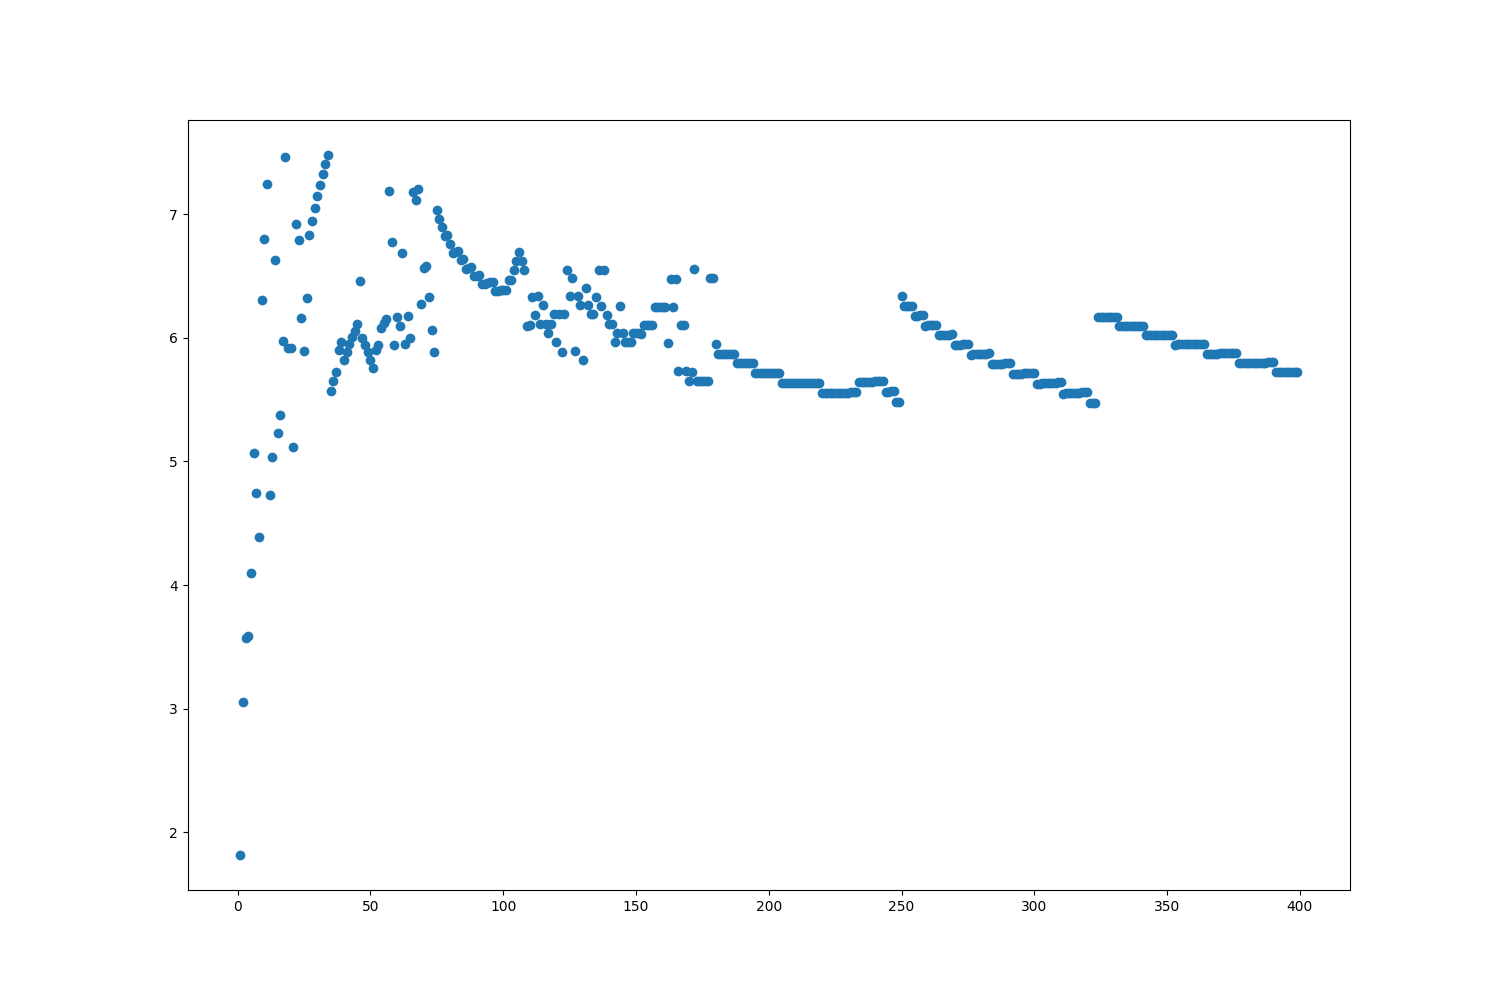

In [111]:
test_ks = np.arange(10, 300, 10)
test_Gs = np.arange(50, 300, 10)
end_vels = []

for g in test_Gs:
    def get_TSA_mult():
        return g
    end_vel = solve_end_vel(i, get_TSA_mult, get_link_mult, doPlot=False)
    end_vels.append(end_vel)

# print(end_vels)
plt.figure()
plt.plot(test_ks, end_vels, 'o')

avg motor speed proportion 0.22900813396663225
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something 

-2.7329603056041054

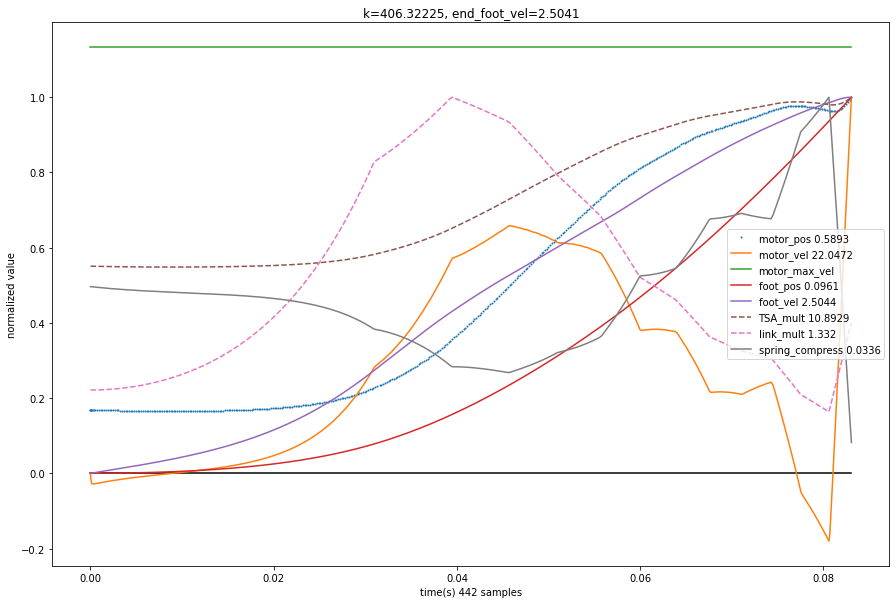

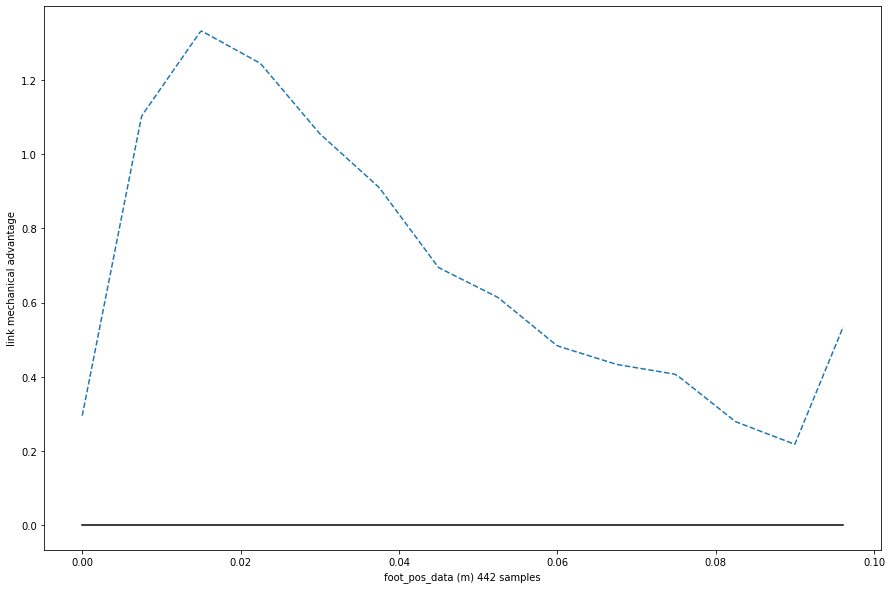

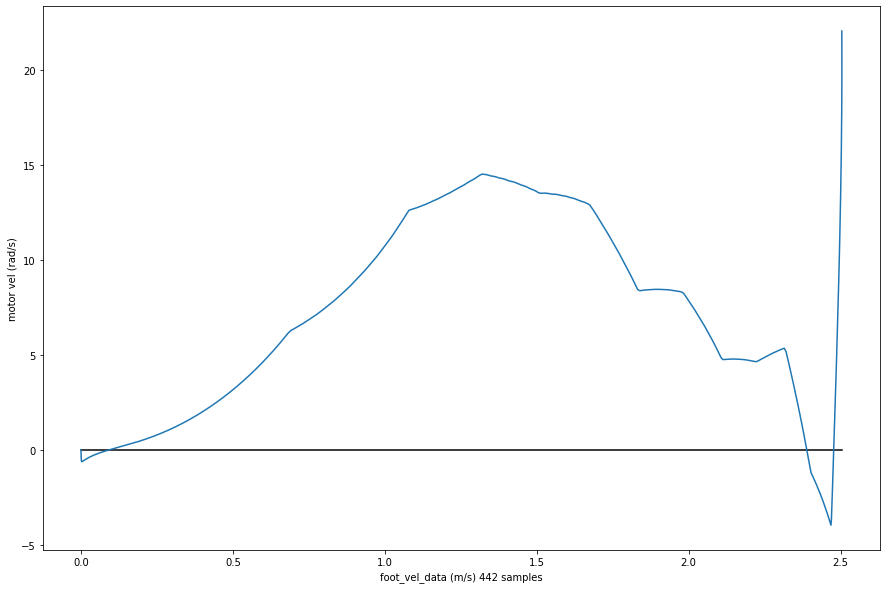

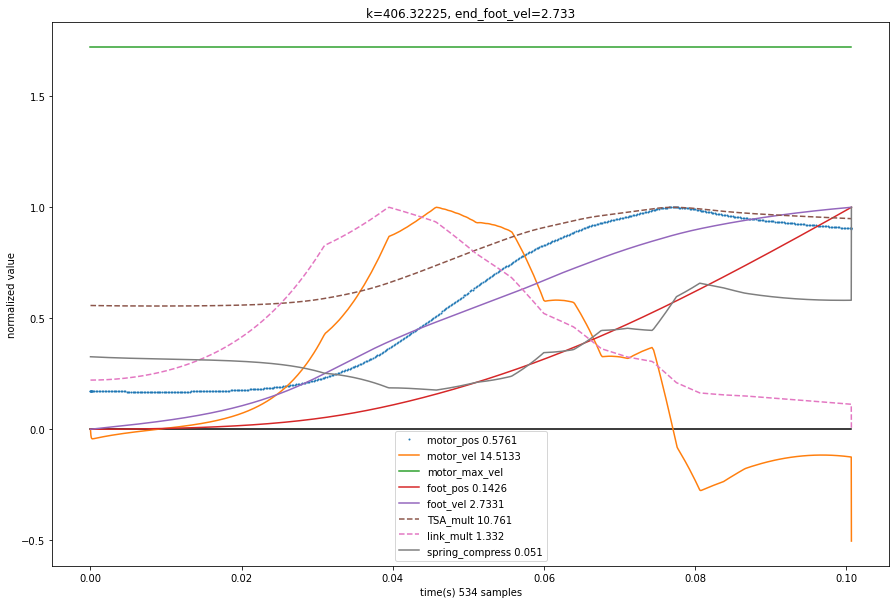

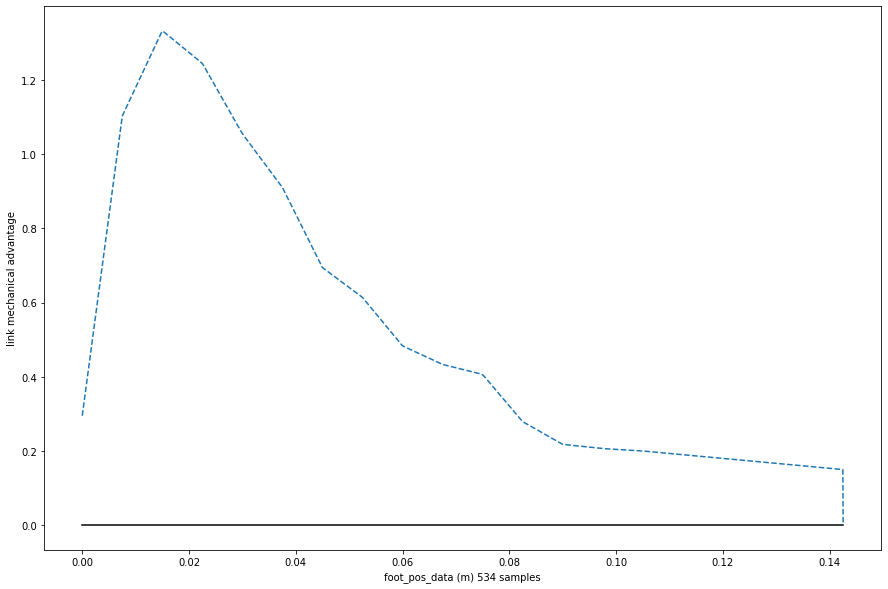

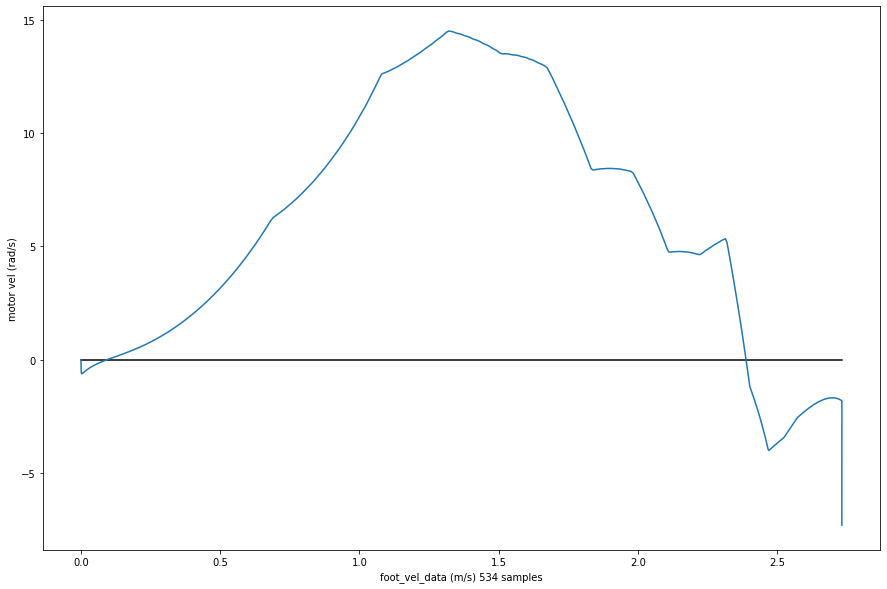

In [ ]:
objective([0.8126445,  0.7,        0.29506861, 1.10287489, 1.33285491, 1.24471512,
 1.05507959, 0.91018567, 0.69434546, 0.61393648, 0.48327344, 0.43336012,
 0.40640418, 0.27914817, 0.21790388, 0.60651354, 0.7,        0.7,
 0.7,        0.7,        0.7,        0.7       ], doPlot=True)

objective([0.8126445,  0.7,        0.29506861, 1.10287489, 1.33285491, 1.24471512,
1.05507959, 0.91018567, 0.69434546, 0.61393648, 0.48327344, 0.43336012,
0.40640418, 0.27914817, 0.21790388, 0.20651354, 0.2,        0.19,
0.18,        0.17,        0.16,        0.15       ], doPlot=True)